# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
# CHeckout this reference this reference(important) : -
#https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1

%matplotlib inline
#Use %matplotlibe inline - this only draws the images, not interactive / zoom-able but it works well.

import warnings
#This is the base class of all warning category classes. It is a subclass of Exception.

warnings.filterwarnings("ignore")
# ignore all the warning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3  # For forming connection between the code and sql
import time

## [1] Reading Data

In [2]:
connection = sqlite3.connect('/home/kushagra/Desktop/Excercise/reviews_dataset/database.sqlite')
data = pd.read_sql_query('''SELECT*FROM Reviews where score != 3 LIMIT 5000''',connection)

def positive_negative(x):
    if x<3:
        return 0
    return 1

filter_data = data['Score'].map(positive_negative)
data['Score'] = filter_data
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# SQL Query for Total Number of users i.e. unique userid's
unique = pd.read_sql_query('''SELECT *,COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1''',connection)
#group by Groups together same UserId's, used with count
unique.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,COUNT(*)
0,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,2
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",3
2,83657,B005ZBZLT4,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...,2
3,290774,B005HG9ESG,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...,3
4,181479,B007OSBEV0,#oc-R12KPBODL2B5ZD,Christopher P. Presta,5,8,1,1348617600,Not what I expected,I didnt like this coffee. Instead of telling y...,2


In [4]:
print('Total number of user = ' ,unique.shape[0]) #Total Number of users i.e. unique userid's
print('Total number of reviews' ,unique['COUNT(*)'].sum())  # Total number of reviews
print("Average review per person = ", unique['COUNT(*)'].sum()/unique.shape[0])

Total number of user =  80668
Total number of reviews 393063
Average review per person =  4.872601279317697


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
x = pd.read_sql_query('''select * from Reviews where UserId = "AR5J8UI46CURR"''',connection)
x
# As you can see there is redundancy.
# This redundancy is due to the fact that one product has many variations for eg:-
# A speaker of same model might have different colors, they will share the same review. Hence this redundancy.
# We need to remove this redundancy because we don't want our data to be baised.
# There might be more other redundancy, you need to figure these redundacy on you own.

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
# There is another type of redundancy. i.e. HelpfulnessNumerator cannot be greater than HelpfulnessDenominator
x = pd.read_sql_query('''select * from Reviews Where "HelpfulnessNumerator">"HelpfulnessDenominator"''',connection)
x

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [7]:
# Need to remove the redundancy discovered above
# Before we remove the redundancy we need to sort the data, then we can use pandas inbuit fn to remove redundancy
# Removing redundancy on sorted data will be faster
sorted_data = data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort',na_position='last') #na_position is the position of NaN data
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [8]:
non_redundant = sorted_data.drop_duplicates(subset={"UserId","Time","ProfileName","Text"},keep='first')
non_redundant = non_redundant[non_redundant['HelpfulnessNumerator']<=non_redundant['HelpfulnessDenominator']]

In [9]:
print(non_redundant.shape)

(4986, 10)


In [10]:
# Percentage of data remained
print("Percentage of data remained = ",(non_redundant["Id"].size*1.0/data["Id"].size*1.0)*100)

Percentage of data remained =  99.72


In [11]:
print(non_redundant.shape)
print(pd.value_counts(non_redundant['Score']))

(4986, 10)
1    4178
0     808
Name: Score, dtype: int64


In [12]:
# Remove the entries that have missing values i.e. Nan Score
print(non_redundant.isna().any())
non_redundant.dropna(axis=0,inplace=True)

Id                        False
ProductId                 False
UserId                    False
ProfileName               False
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                   False
Text                      False
dtype: bool


## [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags and html links
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and remove not alpha-numeric(words made up of alphabets+numbers)
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Perform decontraction
6. Convert the word to lowercase
7. Remove Stopwords
8. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

### [1]. Removing HTML links and tags

In [13]:
# Removing html links
# We need to regular expression package in python to remove html's as the re package has functions that can search for a pattern in text.
# So we will search for html links and susitute them with backspace.
import re
# Here is an example with link
print(non_redundant['Text'].values[0])

print("\n",'='*50,'\n')
print(re.sub(r"http\S+","",non_redundant['Text'].values[0]))
# r is used for creating regular expressions, \S used for non-whitespace
# + used for sequence i.e. \S+   ----> sequence of non-whitespace.
# sub is for subsituting the following pattern with "" .

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


| Code	   | Meaning                                 |
| ---      | ---                                     |
| \d	   | a digit                                 |  
| \D	   | a non-digit                             |
| \s	   | whitespace (tab, space, newline, etc.)  |
| \S	   | non-whitespace                          |      
| \w	   | alphanumeric                            |  
| \W	   | non-alphanumeric                        |       

| Code	   |Meaning                                              |
| ---      | ---                                                 |
| ^	       |start of string, or line                             |                 
| $	       |end of string, or line                               |  
| \A	   |start of string                                      |           
| \Z	   |end of string                                        |        
| \b	   |empty string at the beginning or end of a word       |                     
| \B	   |empty string not at the beginning or end of a word   |


> ## Repetition
> There are five ways to express repetition in a pattern. A pattern followed by the metacharacter * is repeated zero or more times (allowing a pattern to repeat zero times means it does not need to appear at all to match). Replace the * with + and the pattern must appear at least once. Using ? means the pattern appears zero or one time. For a specific number of occurrences, use {m} after the pattern, where m is replaced with the number of times the pattern should repeat. And finally, to allow a variable but limited number of repetitions, use {m,n} where m is the minimum number of repetitions and n is the maximum. Leaving out n ({m,}) means the value appears at least m times, with no maximum.

In [14]:
# Removing html tags
# We need to use BeautifulSoup from bs4
#BeautifulSoap is used for html processing
from bs4 import BeautifulSoup


print(non_redundant['Text'].values[0])
print("\n",'='*50,'\n')

print(BeautifulSoup(non_redundant['Text'].values[0]))
# As you can see here BeautifulSoup converts the text into standard html format.
# This will also help us remove all the html standard tags
print("\n",'='*50,'\n')

text = BeautifulSoup(non_redundant['Text'].values[0])
text = text.get_text() # Extracting text from the html object.
print(text)
# As you can see all the tags have been removed.

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


<html><body><p>Why is this $[...] when the same product is available for $[...] here?<br/>http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br/><br/>The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.</p></body></html>


Why is this $[...] when the same product is available for $[...] here?http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDYThe Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


### [2.] Removing all Special Characters and Punctuations

In [15]:
# Removing all the special characters
# Here is a regex to match a string of characters that are not a letters or numbers:
print(re.sub('[^A-Za-z0-9]+',' ',non_redundant['Text'].values[0]))# the re will search for character that does not contain A-Za-z0-9.
# [^] means not one of the character.
# A character set can also be used to exclude specific characters.
#The special marker ^ means to look for characters not in the set following.

# As you can see "$[...]" is removed. All special characters are removed.

Why is this when the same product is available for here br http www amazon com VICTOR FLY MAGNET BAIT REFILL dp B00004RBDY br br The Victor M380 and M502 traps are unreal of course total fly genocide Pretty stinky but only right nearby 


### [3.] Removing Alfa-Numeric letters

In [16]:
# Removing Alfa-Numeric Words
print(re.sub('\S*\d\S*','',non_redundant['Text'].values[0]))  # \S*  --> Means all character excluding white spaces might occurs 0 or more times
# \d  ----> digit must occur one time.
#\S*\d\S*  ---> eg:- saj3434jkdsd
#This will remove all digits and string with digits.

# As you can see all alpha-numeric letters are removed.

Why is this $[...] when the same product is available for $[...] here?<br  /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


### [4.] Perform Decontraction

In [17]:
# We need to replace words that use short forms such as --> I'm or won't or couldn't or wouldn't etc. to their full form
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

print(non_redundant['Text'].values[900])
# As we can there is "'t" in our sentence. we need to replace all these words to their original words.
print("\n",'='*50,'\n')

# For this to fully work first we need to convert the sentence to lower case.
# Anyways we can are going to use it here as this is just an example.
print(decontraction(non_redundant['Text'].values[900]))

Despite coming in an extremely large box, I found this to be great value. All the bags were preserved with a reasonable expiration date that is months away. I'd definitely recommend.


Despite coming in an extremely large box, I found this to be great value. All the bags were preserved with a reasonable expiration date that is months away. I would definitely recommend.


### [5.] Converting to Lower Case

In [18]:
def lower_case(sentence):
    sentence = ' '.join(e.lower() for e in sentence.split())
    return sentence

print(lower_case(non_redundant['Text'].values[900]))

despite coming in an extremely large box, i found this to be great value. all the bags were preserved with a reasonable expiration date that is months away. i'd definitely recommend.


### [6.] Removing Stop Words

In [19]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have removed in the 1st step
# https://gist.github.com/sebleier/554280

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
# Creating sets of stop keywords

def rm_stop_words(sentence):
    sentence = ' '.join(e for e in sentence.split() if e not in stopwords)
    return sentence

print(non_redundant['Text'].values[900])
print("\n",'='*50,'\n')
print(rm_stop_words(non_redundant['Text'].values[900]))

Despite coming in an extremely large box, I found this to be great value. All the bags were preserved with a reasonable expiration date that is months away. I'd definitely recommend.


Despite coming extremely large box, I found great value. All bags preserved reasonable expiration date months away. I'd definitely recommend.


### [7.] Stemming the words

In [20]:
# As snow ball stemming is better than porter stemming we are going to use snow ball stemming
from nltk.stem import SnowballStemmer
print(" ".join(SnowballStemmer.languages)) # languages supported by th snowball stemming

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [21]:
stemmer = SnowballStemmer('english') # Selecting english language for stemming
stemmer.stem('manly')

'man'

### Now we need to use all these technique at one to apply at our Amazon Fine Food DataSet

In [22]:
from tqdm import tqdm
import pdb
# This package is used for visualizing loading status bar
# https://gist.github.com/sebleier/554280

null_review = []

preprocessed_review = []
for count, review in tqdm(enumerate(non_redundant['Text'].values)):
    review = re.sub(r'http\S+','',review)
    review = BeautifulSoup(review).get_text()
    
    # There were many cases where review became ' '(empty), after implementing this line of code "re.sub(r'http\S+','',review)" \n
    # For example review number 24:-
    # '<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happ
    # Here, if http(link) is removed, "http://www.amazon.com/gp/product/B0000VMBDI">WILTON" This string will be removed.
    # Hence removing ">", which will create incorrect index.
    # Thus BeautifulSoup(review).get_text() will return ' '
    # BeautifulSoup(review).get_text() will result in empty string. For example check review number 24,121,456 and 601
    # That's why I have used the code below
    
    if review == '' or review == ' ':
        null_review.append(count)
        continue
    review = re.sub('[^A-Za-z0-9]+',' ',review)  # This line of code should be carefully written.
    # If ' ' space is not given in subsituition, then the words will cramp
    # If * is used instead of + , then all letter will have spacing
    review = re.sub('\S*\d\S*','',review)
    review = ' '.join(e.lower() for e in review.split() if e.lower() not in stopwords) #Removing Stop words and loweri casing letter at same time.
    review = decontraction(review)
    preprocessed_review.append(' '.join(list(map(stemmer.stem, review.split(' ')))))

4986it [00:04, 1043.77it/s]


In [23]:
print(len(preprocessed_review))
print(null_review)

4971
[24, 121, 456, 601, 718, 792, 1042, 1136, 1183, 1272, 1781, 1816, 2023, 2107, 2353]


### __*Run the below cell if you don't want to stem your text.*__

In [24]:
print(preprocessed_review[1500])
print('\n',len(preprocessed_review))
print(type(preprocessed_review))

realli great tast cooki like combin peanut butter chocol nice chang usual chocol chip cooki

 4971
<class 'list'>


# [4.] Featurization

## [4.1] Bag of Words

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
cv = CountVectorizer(min_df=10, max_features=5000)
bow = cv.fit(preprocessed_review)
#https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

print(bow.get_feature_names()[100:120])
print('='*60)
bow = cv.transform(preprocessed_review)
X = bow.copy()
fit_bow = Normalizer().fit(X)   # Standard Normalization
print(fit_bow)
bow = fit_bow.transform(X)
print("Type Vectorizer ",type(bow))
print("Shape of Sparse Matrix ",bow.shape)
print("Total number of words in BOW ",bow.shape[1])

['awhil', 'babi', 'back', 'bacon', 'bad', 'bag', 'bake', 'baker', 'balanc', 'ball', 'banana', 'bar', 'barbecu', 'barbequ', 'bare', 'bargain', 'base', 'basi', 'basic', 'basil']
Normalizer(copy=True, norm='l2')
Type Vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
Shape of Sparse Matrix  (4971, 1852)
Total number of words in BOW  1852


## [4.2] Bi-Grams\N-Grams

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice

# max_features https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features
# max_features only select those number of features that occur the most.
# For eg here, select the top 5000 features that occur the most in corpus.
#min_df(document frequency) and max_df explained  https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
#Here min_df means ignore the word if it appers less than 10 documents
#You can also give min_df in float, in float the value is considered as percentage
#For eg:- min_df = 0.10, Then Ignore the feature if it appears in less than 10% of documents

CV = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000) #ngrams_range(lower,upper)
# ngram_range  https://www.kaggle.com/c/avito-demand-prediction/discussion/58819
# In ngrams_range we give range of lower_gram and upper_gram
# The function will return matrix of grams from lower_gram to upper_gram
# for example ngrams_range(1,3)  ---> return matrix of uni,bi,tri grams

bow = CV.fit_transform(preprocessed_review)
print("the type of count vectorizer ",type(bow))
print("the shape of our text BOW vectorizer ",bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", bow.get_shape()[1])

X = bow.copy()
fit_bow = Normalizer().fit(X)   # Standard Normalization
print(fit_bow)
bow = fit_bow.transform(X)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW vectorizer  (4971, 2932)
the number of unique words including both unigrams and bigrams  2932
Normalizer(copy=True, norm='l2')


## [4.3] TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
tfidf = tfidf.fit(preprocessed_review)
print(tfidf.get_feature_names()[100:110])

tfidf = tfidf.transform(preprocessed_review)
print("="*50,"\nthe type of count vectorizer ",type(bow))
print("the shape of our text tf-idf vectorizer ",tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf.get_shape()[1])

X = tfidf.copy()
fit_tfidf = Normalizer().fit(X)   # Standard Normalization
print(fit_tfidf)
bow = fit_tfidf.transform(X)

['apart', 'appar', 'appeal', 'appear', 'appl', 'appl cinnamon', 'appreci', 'area', 'argentina', 'aroma']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text tf-idf vectorizer  (4971, 2932)
the number of unique words including both unigrams and bigrams  2932
Normalizer(copy=True, norm='l2')


## [4.4] Word2Vector

__Word2Vector is an algorithm made by google that gives you a numeric vector corresponding to the word you give the algorithm as input, This vector can be used to find similarity between the words and can group together similar words. Although we can use this algo on our review dataset, google has provided us with it's own dataset, each word have 300 dimensions vector and the weights are trained on GoogleNews.__

In [28]:
# If we want to use w2v we need to convert our data to tokens i.e. list of list.
# Here each ducument will be a list whose words are element of the list.
# All the documents will be contained in a bigger list i.e. Corpous
corpus=[]
for document in preprocessed_review:
    corpus.append(document.split(' '))
    
print(corpus[10])
print(len(corpus))

['bought', 'brand', 'onlin', 'indian', 'groceri', 'store', 'usual', 'excel', 'product', 'abl', 'turn', 'cream', 'butter', 'use', 'super', 'blender', 'ad', 'water', 'bare', 'flavor', 'usual', 'buy', 'chao', 'kah', 'brand', 'coconut', 'cream', 'quit', 'tasti', 'flavor', 'read', 'anoth', 'review', 'differ', 'product', 'make', 'coconut', 'cream', 'complaint', 'not', 'shred', 'textur', 'mine', 'virtual', 'tasteless']
4971


In [29]:
# Here is a really good article on Word2Vector
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XR0cft9fiXJ
from gensim.models import Word2Vec  
from gensim.models import KeyedVectors

model = Word2Vec(corpus,size=150,window=10,min_count=5,workers=4)
# size is number of dimensions of vector that you want to build
# window is the maximum distance between two similar words
# min_count is the minimum number of times the word must appear in corpus
# workers is the numbers of cpu that you want to use

# Read the above article to know about these arguments if full detail

In [30]:
print(model.wv.most_similar('bad',topn=15)) #topn specifes number of examples in output.

[('probabl', 0.9988856315612793), ('wrong', 0.9987560510635376), ('particular', 0.9987494945526123), ('select', 0.9986460208892822), ('brother', 0.9986040592193604), ('though', 0.9985812306404114), ('stand', 0.9985764026641846), ('rather', 0.9985702037811279), ('comparison', 0.9985566735267639), ('worst', 0.9985519051551819), ('peet', 0.9985250234603882), ('metal', 0.9985217452049255), ('interest', 0.9985203742980957), ('tongu', 0.9984678030014038), ('experi', 0.9984482526779175)]


In [31]:
print(model.wv.most_similar('good'))
print('\n')
print(model.wv.similarity('good','tasti'))
print('\n')
print(model.wv.most_similar('smell'))

[('burnt', 0.9962985515594482), ('minti', 0.9952001571655273), ('peppermint', 0.9951410889625549), ('overpow', 0.9948368072509766), ('intens', 0.994821310043335), ('full', 0.994660496711731), ('enjoy', 0.9946119785308838), ('subtl', 0.9943259954452515), ('raspberri', 0.9942445755004883), ('mild', 0.9941028356552124)]


0.98243064


[('bodi', 0.9988893270492554), ('sip', 0.998537540435791), ('leav', 0.9984830617904663), ('mahogani', 0.9980046153068542), ('silki', 0.997954249382019), ('caffein', 0.9979242086410522), ('warm', 0.9979063868522644), ('starbuck', 0.9978428483009338), ('distinct', 0.9978122711181641), ('steep', 0.9977496266365051)]


In [32]:
print(model.wv.most_similar('worst'))
print('\n')
print(model.wv.most_similar('pack'))
print('\n')
print(model.wv.most_similar('cooki'))

[('comparison', 0.999592661857605), ('stand', 0.999571681022644), ('somewhat', 0.999557375907898), ('type', 0.9994974732398987), ('odd', 0.9994385242462158), ('noth', 0.9994346499443054), ('yet', 0.9994301795959473), ('although', 0.9994018077850342), ('tasteless', 0.9993439316749573), ('licoric', 0.9993276596069336)]


[('bag', 0.986711323261261), ('case', 0.9830027222633362), ('deal', 0.9766418933868408), ('could', 0.9699530601501465), ('arriv', 0.9687688946723938), ('pay', 0.9670761823654175), ('avail', 0.9670318365097046), ('onlin', 0.9669051170349121), ('would', 0.9668295383453369), ('per', 0.9667013883590698)]


[('pop', 0.9923581480979919), ('wafer', 0.9921699166297913), ('crispi', 0.9919246435165405), ('ahoy', 0.9916294813156128), ('crisp', 0.9914143681526184), ('oreo', 0.9911791682243347), ('barbecu', 0.9906979203224182), ('origin', 0.9903926253318787), ('serv', 0.9902499914169312), ('barbequ', 0.9901878237724304)]


In [33]:
print(len(model.wv.vocab)) # Total number of words in our vocabulary
print(type(model.wv.vocab))
print("Some words :",list(model.wv.vocab)[1000:1010])

2991
<class 'dict'>
Some words : ['difficult', 'close', 'proper', 'side', 'air', 'oxid', 'import', 'stale', 'rancid', 'human']


In [34]:
vocabulary = model.wv.vocab

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# Compute Average Word2Vector
avg_list = []
for review in tqdm(preprocessed_review):
    vec = np.zeros(150)
    avg_vec = np.zeros(150)
    count = 0
    for word in review.split(' '):
        if word in vocabulary:
            vec += model.wv[word]
            count+=1
    if count != 0:
        vec =vec/count
    avg_list.append(vec)

avg_list = Normalizer().fit_transform(avg_list)    

print(len(avg_list))  #Length of the list
print(len(avg_list[1])) # Length of average vector

100%|██████████| 4971/4971 [00:00<00:00, 5625.31it/s]


4971
150


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
model_tfidf = TfidfVectorizer()
model_tfidf.fit(preprocessed_review)  #Do not use fit_transform here or else you would not be able to use get_feature_names() on model
# we are converting a dictionary with word as a key, and the idf as a value
# Note : Here we are getting only IDF, we need to find TF ourself
dictionary = dict(zip(model_tfidf.get_feature_names(), list(model_tfidf.idf_)))

In [37]:
print(preprocessed_review[121])

soy milk scrumptious varieti extra nutrient ad great nutriti high calcium no cholesterol product great price buy case


In [38]:
# TF-IDF weighted Word2Vec
import pdb
tfidf_vocab = model_tfidf.get_feature_names()

tfidf_weighted_list = []
for sentence in tqdm(preprocessed_review):
    vec = np.zeros(150)
    sum_vec = np.zeros(150)
    sum_tfidf=0
    len_sentence = len(sentence.split(' '))
    for word in sentence.split(' '):
        if word in tfidf_vocab and word in vocabulary:
            vec = model.wv[word]
            tfidf_ = dictionary[word]*(sentence.count(word)/len_sentence)
            sum_vec +=(tfidf_*vec)
            sum_tfidf +=tfidf_
    if sum_tfidf!=0:
        sum_vec/=sum_tfidf
    tfidf_weighted_list.append(sum_vec)
    
tfidf_weighted_list = Normalizer().fit_transform(tfidf_weighted_list)

100%|██████████| 4971/4971 [00:18<00:00, 263.18it/s]


In [39]:
print(len(tfidf_weighted_list))
print(null_review)

4971
[24, 121, 456, 601, 718, 792, 1042, 1136, 1183, 1272, 1781, 1816, 2023, 2107, 2353]


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='red'>Note 1: The TSNE accepts only dense matrices</font></li>

## [5.1] Applying TSNE on Text BOW vectors

In [59]:
from sklearn.manifold import TSNE


bow_matrix = bow.todense()  # First we need to convert sparse.csr matrix to numpy array/matrix.
#Then only we can apply t-SNE on the data. todense() function converts sparse matrix to dense/numpy matrix

tsne = TSNE(n_components=2, perplexity =30, random_state=0)
tsne_vec = tsne.fit_transform(bow_matrix) # Computing TSNE Vector

In [60]:
dropping_review = non_redundant['Score'].drop(null_review)
labels = pd.DataFrame(dropping_review.to_numpy())
labels.shape

(4971, 1)

In [61]:
print(tsne_vec.shape)

data = np.hstack((tsne_vec, labels))  # Adding label to the tsne vector.
#Our label are positive and negative examples. As we classified above.

(4971, 2)


In [62]:
print(data.shape)

data = pd.DataFrame(data,columns=('X','Y','label'))  # Converting to dataframe so we can use hue to plot graph

(4971, 3)


In [63]:
print(data.iloc[0])

X        13.475497
Y        15.933870
label     1.000000
Name: 0, dtype: float64


<IPython.core.display.Javascript object>


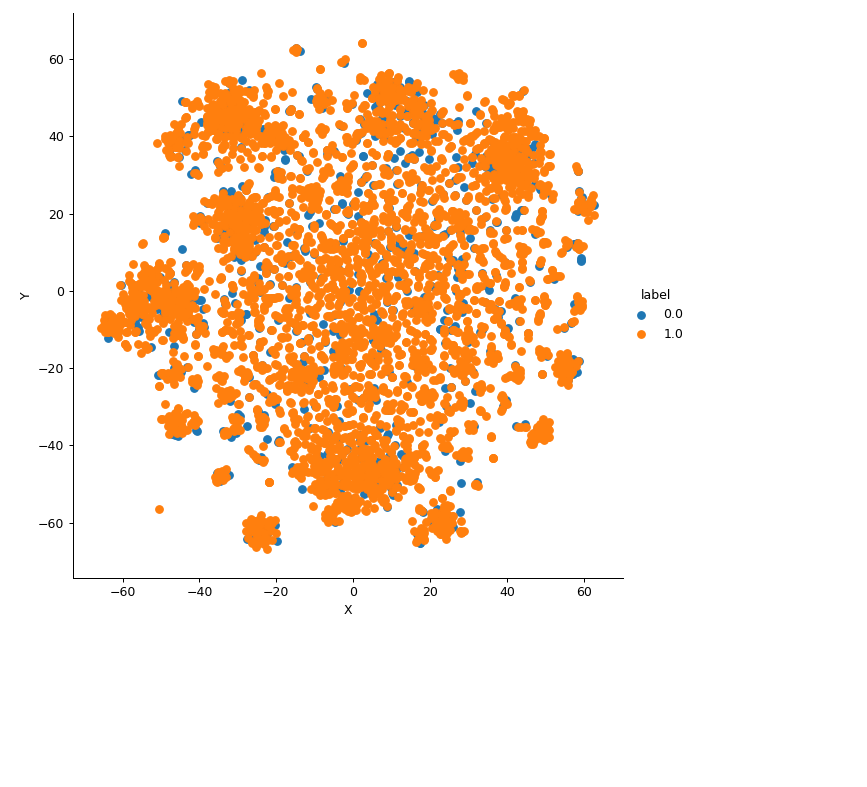

In [64]:
%matplotlib notebook
import matplotlib.pyplot as plt
sns.FacetGrid(data=data,hue='label',height=7).map(plt.scatter,'X','Y').add_legend() # Plotting Scatter plots
plt.show()

In [46]:
import sys
import os
clear = lambda: os.system('cls')
clear()

32512

## [5.1] Applying TSNE on Text TFIDF vectors

In [47]:
tfidf = tfidf.todense()
tfidf = tsne.fit_transform(tfidf)

In [48]:
tf_idf_matrix = np.hstack((tfidf, labels))
tf_idf_matrix = pd.DataFrame(tf_idf_matrix,columns=('X','Y','label'))

<IPython.core.display.Javascript object>


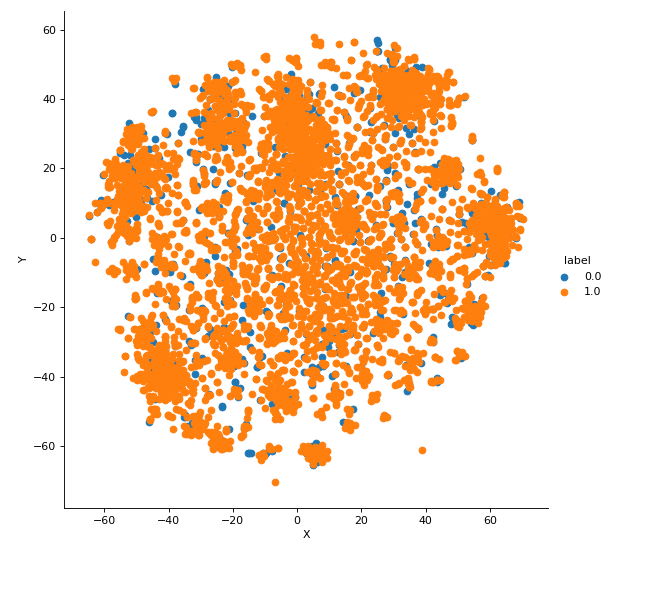

In [49]:
sns.FacetGrid(data=tf_idf_matrix,hue='label',height=7).map(plt.scatter,'X','Y').add_legend()
plt.show()

## [5.3] Applying TSNE on Text Avg W2V vectors

In [50]:
# Here our data is list of lists instead of matrix so we convert it to matrix first.
# Here I have used reduce function for rolling computation and coverting all the lists to matrix

from functools import reduce
import pdb
def reduce_fn(v1,v2):
    return np.vstack((np.array(v1),np.array(v2)))
taw2v = reduce(reduce_fn,np.array(avg_list))
taw2v.shape

(4971, 150)

In [51]:
taw2v_vec = tsne.fit_transform(taw2v)  # Applying TSNE
print(taw2v_vec.shape)

(4971, 2)


In [52]:
print(labels.shape)
print(taw2v_vec.shape)

(4971, 1)
(4971, 2)


In [53]:
taw2v_tsne = np.hstack((taw2v_vec,labels))  # Adding label to our Data. Positive and Negative Example
taw2v_tsne = pd.DataFrame(taw2v_tsne,columns=('X','Y','label'))

<IPython.core.display.Javascript object>


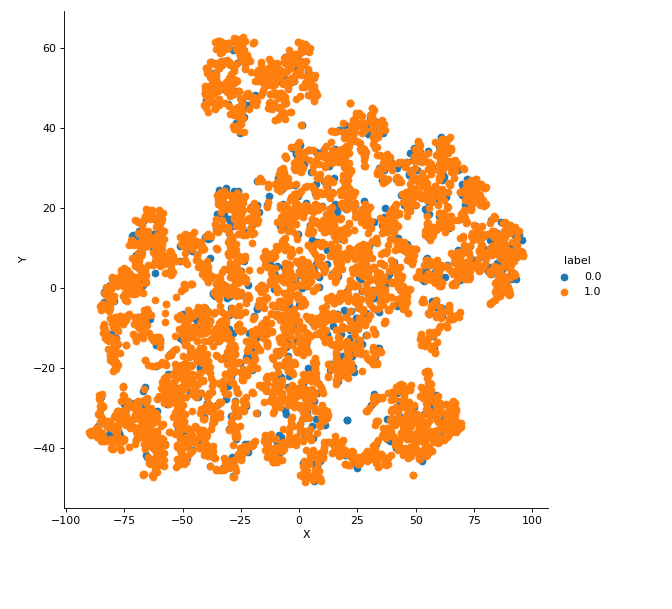

In [54]:
sns.FacetGrid(data=taw2v_tsne,hue='label',height=7).map(plt.scatter,'X','Y').add_legend()
plt.show()

## [5.4] Applying TSNE on Text TFIDF weighted W2V vectors

In [55]:
print(len(tfidf_weighted_list))
tfidf_weighted_list = reduce(reduce_fn,np.array(tfidf_weighted_list))

4971


In [56]:
print(tfidf_weighted_list.shape)
tfidfw2v_vec = tsne.fit_transform(tfidf_weighted_list)
print(tfidfw2v_vec.shape)

(4971, 150)
(4971, 2)


In [57]:
print(labels.shape)
print(tfidfw2v_vec.shape)

(4971, 1)
(4971, 2)


In [58]:
tfidfw2v = np.hstack((tfidfw2v_vec,labels))
tfidfw2v = pd.DataFrame(tfidfw2v,columns=('X','Y','label'))

In [59]:
print(tfidfw2v.iloc[0])

X        27.885818
Y       -56.296467
label     1.000000
Name: 0, dtype: float64


<IPython.core.display.Javascript object>


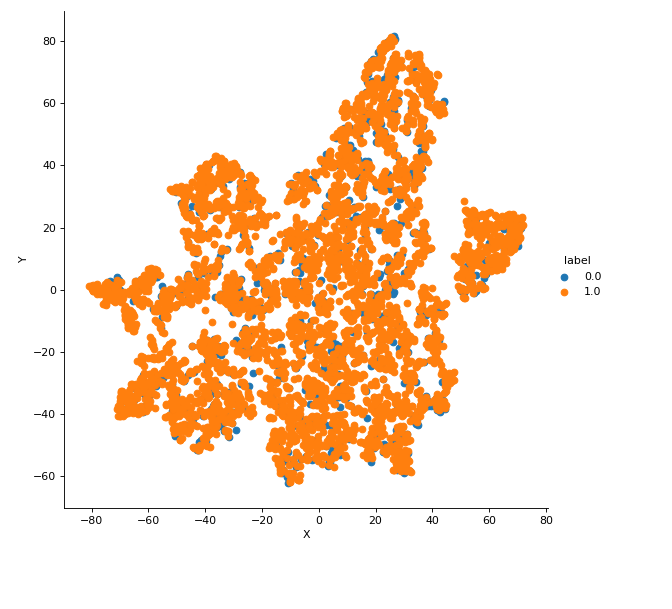

In [60]:
sns.FacetGrid(data=tfidfw2v,hue='label',height=7).map(plt.scatter,'X','Y').add_legend()
plt.show()

# [6] Conclusions

- In Bag of Words Implementation positive and negative reviews are fully overlapping and all the data points are clustered at same place except some points which are very far away from the other data points. We cannot classify these examples. Using more data points may show some Distinguishment.
- In case of TFIDF, the is centered are fairly scattered but still the positive and negative's points cannot be comprehended.
- In Average W2V implementation, we can see some smaller clusters but still data points are overlapped very fully.
- In TFIDF weighted W2V implementation, there is no clear differentiation.
- In conclusion, All the above 4 techniques and are not able to differentiate the positive and negative reviews. We might see some differentiation if we use more data points.

In [61]:
import gc
gc.collect()

161